# 콘크리트 강도를 예측하는 의사결정나무 모델을 만들고 predict method를 이용하여 예측값을 구하라. 그리고 모델의 mse와 mae를 산출하여 비교하라. 
데이터 : Concrete.CSV(변수: 9개, 자료 수: 1,030개)
 -.목표변수(Concrete_compressive_strength)
 
 ※ 데이터는 ( train(0.4) : validation(0.3) : test(0.3) )의 비율로 분할 (train_test_split 활용)
 0. train_test_split 함수를 이용하여 train:test로 데이터 분할. 분할된 train 데이터를 재 분할하여 validation 데이터로 사용
 1. train 데이터: 모델 훈련 
 2. validation 데이터: 최적의 parameter 찾기(과정의 [연습/실습]에서 test 데이터 역할)
 3. test 데이터: 2에서 찾은 최적의 parameter를 이용하여 만든 모델로 최종 성능 확인(단 한 번만 사용할 것)

In [1]:
# 의사결정나무 모델 생성에 필요한 라이브러리를 import

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse  # 추정의 표준오차
%matplotlib inline

from sklearn.tree import export_graphviz
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV   # cross validation(구버전)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import metrics 

In [2]:
#Concrete.csv을 불러옴
df_raw = pd.read_csv("/home/pirl/Downloads/BigDataAnalysis/Concrete.csv", engine = "python")
df_raw.head()

,CEMENT,BLAST_FURNACE_SLAG,FLY_ASH,WATER,SUPERPLASTICIZER,COARSE_AGGREGATE,FINE_AGGREGATE,AGE,CONCRETE_COMPRESSIVE_STRENGTH
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [3]:
# 목표변수, 설명변수 데이터 지정
df_raw_y = df_raw["CONCRETE_COMPRESSIVE_STRENGTH"]
df_raw_x = df_raw.drop("CONCRETE_COMPRESSIVE_STRENGTH", axis= 1, inplace = False)

In [8]:
# train_set_split(x:설명변수 데이터, Y: 목표변수 데이터, test_size=test 데이터 비율, random_state: random seed)
# train_set_split 함수를 이용하여 데이터는 ( train(0.4) : validation(0.3) : test(0.3) )의 비율로 분할
# train_test_split 함수를 이용하여 train:test로 데이터 분할. 분할된 train 데이터를 재 분할하여 validation 데이터로 사용
#random state=87로 지정하여 입력 데이터 고정
df_train_x, df_rest_x, df_train_y, df_rest_y= train_test_split(df_raw_x, df_raw_y, test_size=0.6, random_state=87)
df_validation_x, df_test_x, df_validation_y, df_test_y= train_test_split(df_rest_x, df_rest_y, test_size=0.5, random_state=87)

print("train data X size:{}".format(df_train_x.shape))
print("train data Y size:{}".format(df_train_y.shape))
print("validation data X size:{}".format(df_validation_x.shape))
print("validation data Y size:{}".format(df_validation_y.shape))
print("test data X size:{}".format(df_test_x.shape))
print("test data Y size:{}".format(df_test_y.shape))

train data X size:(412, 8)
train data Y size:(412,)
validation data X size:(309, 8)
validation data Y size:(309,)
test data X size:(309, 8)
test data Y size:(309,)


In [9]:
# DecisionTreeRegressor을 이용하여 의사결정나무 생성
tree_uncustomized = DecisionTreeRegressor(random_state = 87)
tree_uncustomized.fit(df_train_x, df_train_y)
# Train 데이터 설명력
print("Score on training set: {:.3f}".format(tree_uncustomized.score(df_train_x, df_train_y)))
# test 데이터 설명력
print("Score on validation set: {:.3f}".format(tree_uncustomized.score(df_validation_x, df_validation_y)))

Score on training set: 0.999
Score on validation set: 0.738


In [10]:
#parameter 값 출력
tree_uncustomized

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=87, splitter='best')

In [11]:
# 잎사귀 노드의 최소 자료 수를 1~30인 경우를 내림차순으로 출력
# train_score에는 df_train 데이터를 분류한 결과를 저장
# validation_score df_validation 데이터를 분류한 결과를 저장

train_score=[]; validation_score=[]
para_leaf=[n_leaf * 1 for n_leaf in range(1,30)]

for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeRegressor(random_state = 87, min_samples_leaf = v_min_samples_leaf)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    validation_score.append(tree.score(df_validation_x, df_validation_y))

# 각 MinSamplesLeaf 수에 따른 TrainScore와 ValidationScore을 각 변수에 저장
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"]=para_leaf
df_score_leaf["TrainScore"]=train_score
df_score_leaf["ValidationScore"]=validation_score

In [103]:
# 각 MinSamplesLeaf 수에 따른 TrainScore와 ValidationScore을 내림차순으로 출력
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,1.000,0.746
1,2,0.980,0.699
2,3,0.950,0.755
3,4,0.929,0.777
4,5,0.910,0.778
5,6,0.895,0.767
6,7,0.874,0.734
7,8,0.857,0.728
8,9,0.849,0.736
9,10,0.836,0.739


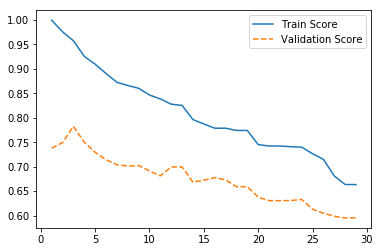

In [12]:
# 위의 값을 그래프로 출력
plt.plot(para_leaf,train_score,linestyle="-", label = "Train Score")
plt.plot(para_leaf,validation_score,linestyle="--", label = "Validation Score")
plt.legend()
# 차이가 가장 적으면서, 전체적으로 score가 높은 MinSamplesLeaf 선정 = 4

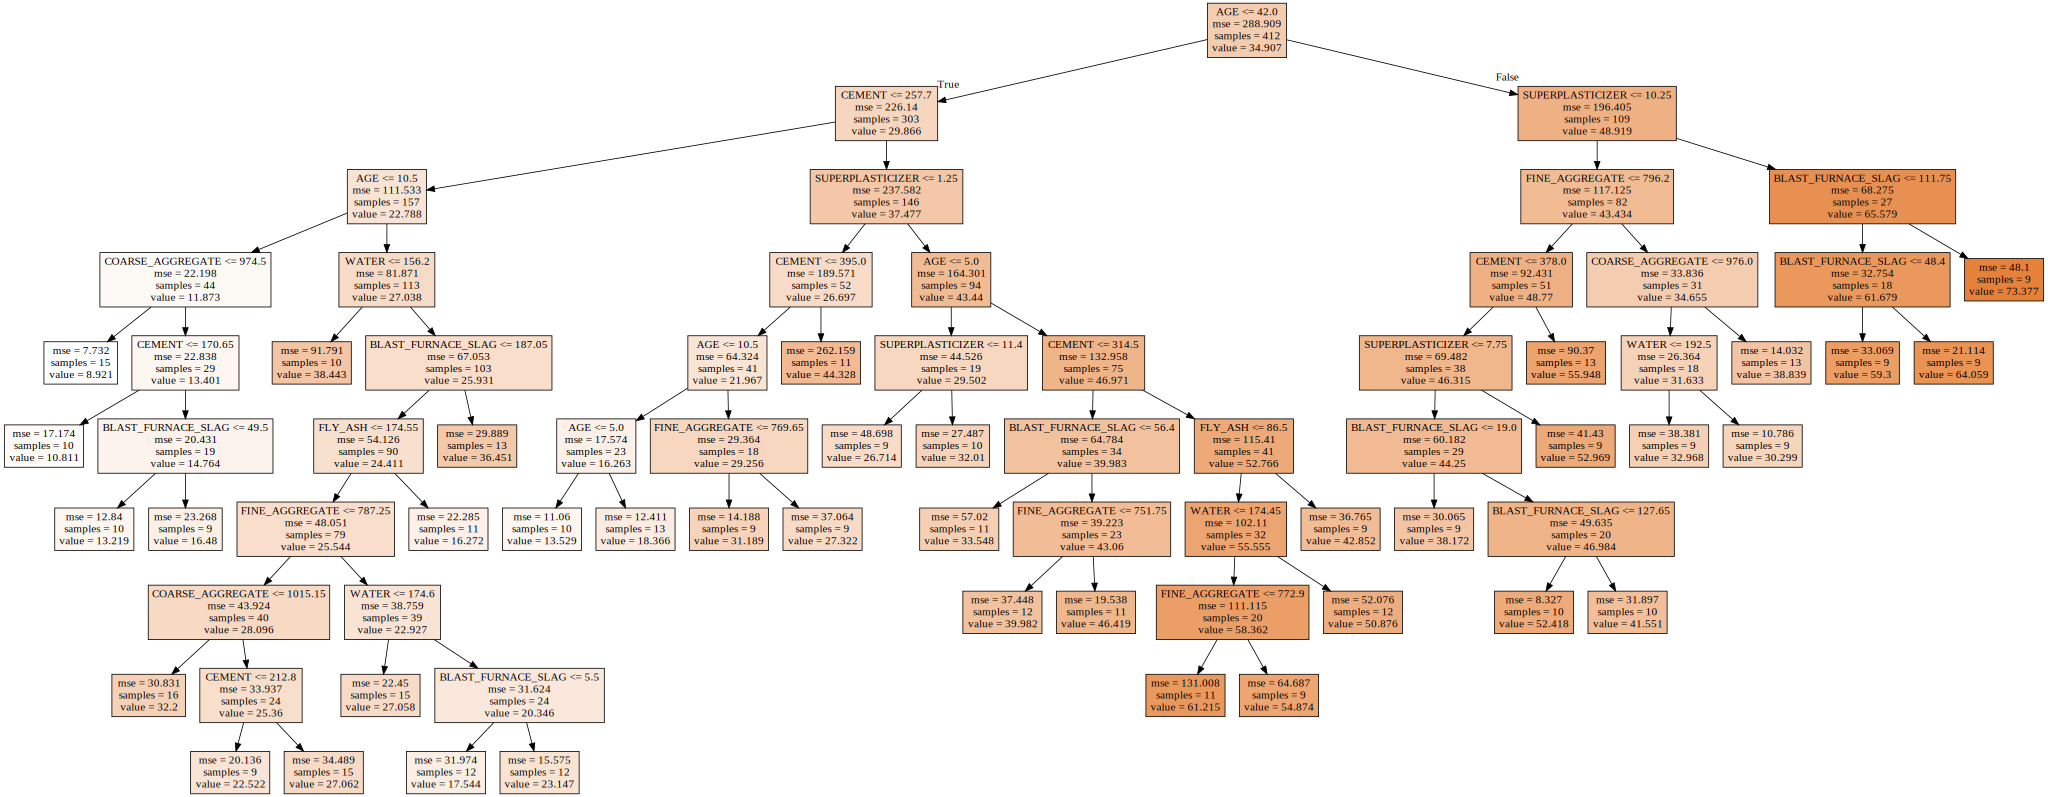

In [14]:
# min_samples_leaf=4을 고정하고, 나머지는 디폴트 값으로 한 의사결정트리 그래프 출력
v_feature_name = df_train_x.columns
tree_graph = DecisionTreeRegressor(random_state=87, min_samples_leaf = 9)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file="tree_leaf.dot",feature_names=v_feature_name, impurity=True, filled=True)
with open("tree_leaf.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

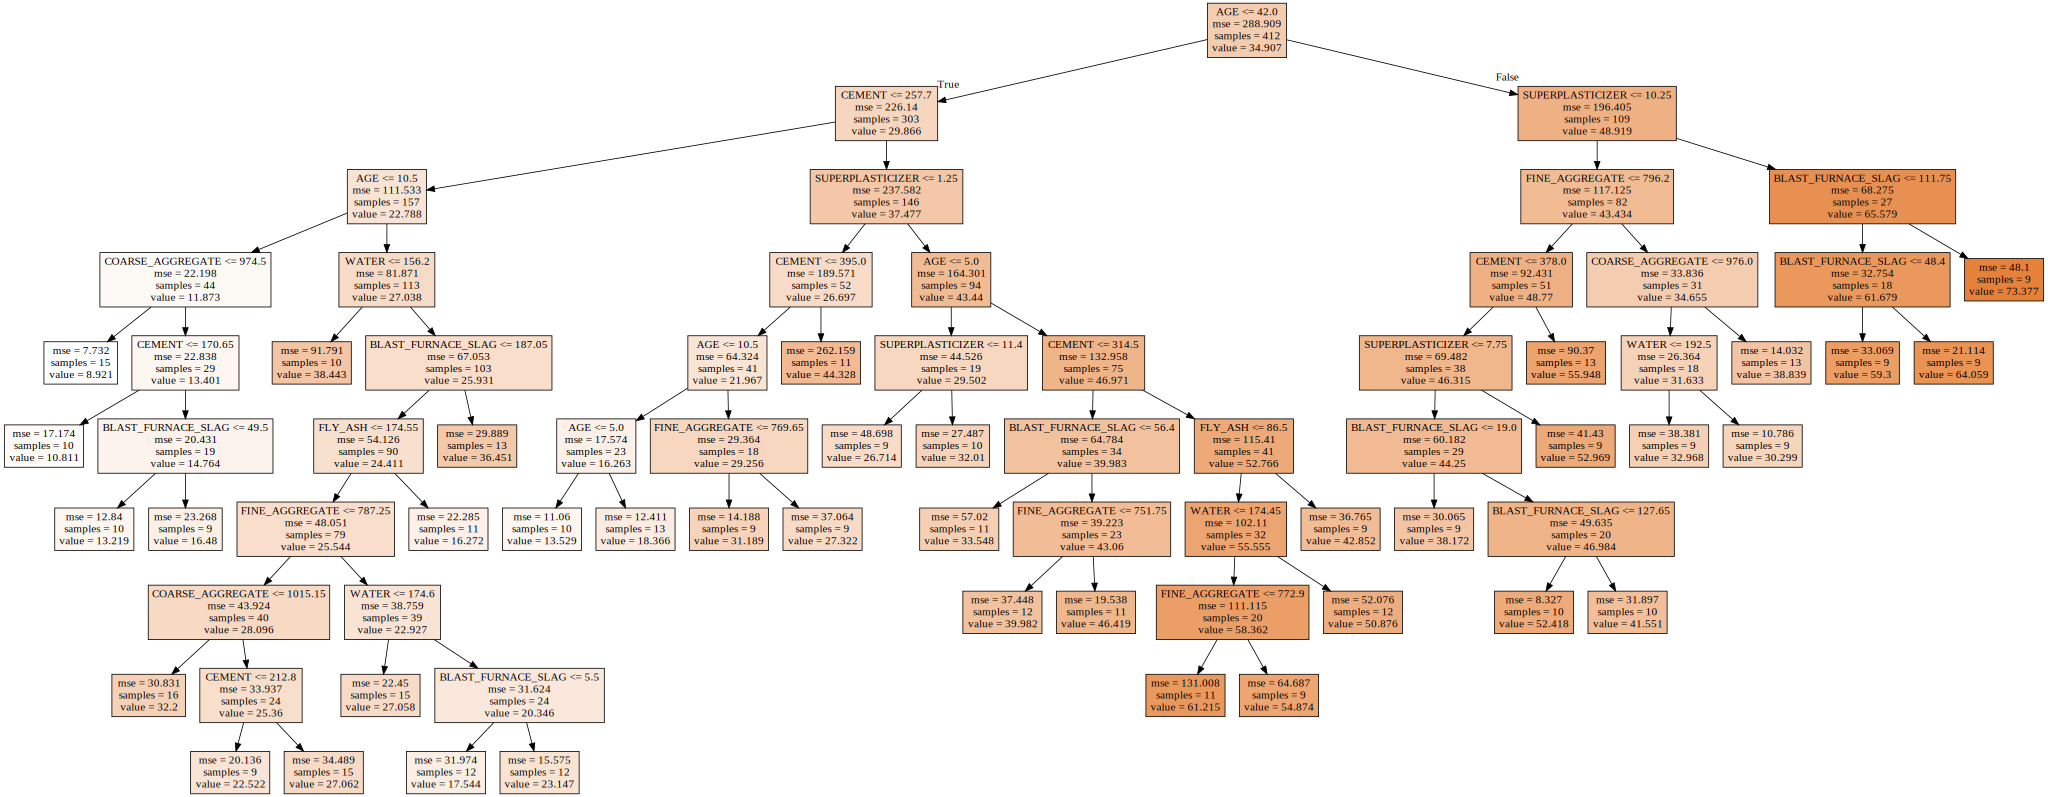

In [15]:
# p.164
v_feature_name = df_train_x.columns
tree_graph = DecisionTreeRegressor(random_state=87, min_samples_leaf=9)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file="tree_leaf.dot",feature_names=v_feature_name, impurity=True, filled=True)
with open("tree_leaf.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

# conda에서 graphviz 설치!!

In [17]:
# 위에서 선택된 min_samples_leaf를 기반으로 min_samples_split 값을 최소 min_samples_leaf의 2배부터 일정 구간까지 반복하여 의사결정트리 출력

train_score = []; validation_score = []
para_split = [n_split * 2 for n_split in range(9,30)]

for v_min_samples_split in para_split:
    tree = DecisionTreeRegressor(random_state = 87, min_samples_leaf=9, min_samples_split=v_min_samples_split)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    validation_score.append(tree.score(df_validation_x, df_validation_y))
    
df_score_split = pd.DataFrame()
df_score_split["MinSamplesSplit"]=para_split
df_score_split["TrainScore"]=train_score
df_score_split["ValidationScore"]=validation_score
df_score_split.round(3)

,MinSamplesSplit,TrainScore,ValidationScore
0,18,0.860,0.702
1,20,0.857,0.690
2,22,0.850,0.696
3,24,0.847,0.689
4,26,0.845,0.685
5,28,0.838,0.672
6,30,0.833,0.669
7,32,0.830,0.670
8,34,0.826,0.676
9,36,0.820,0.664


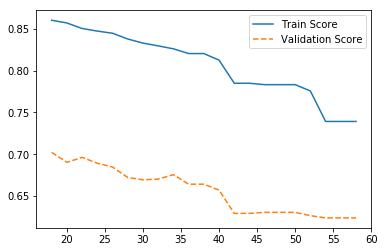

In [18]:
# Train Score와 Validation Score 그래프 출력
plt.plot(para_split,train_score,linestyle="-", label = "Train Score")
plt.plot(para_split,validation_score,linestyle="--", label = "Validation Score")
plt.legend()

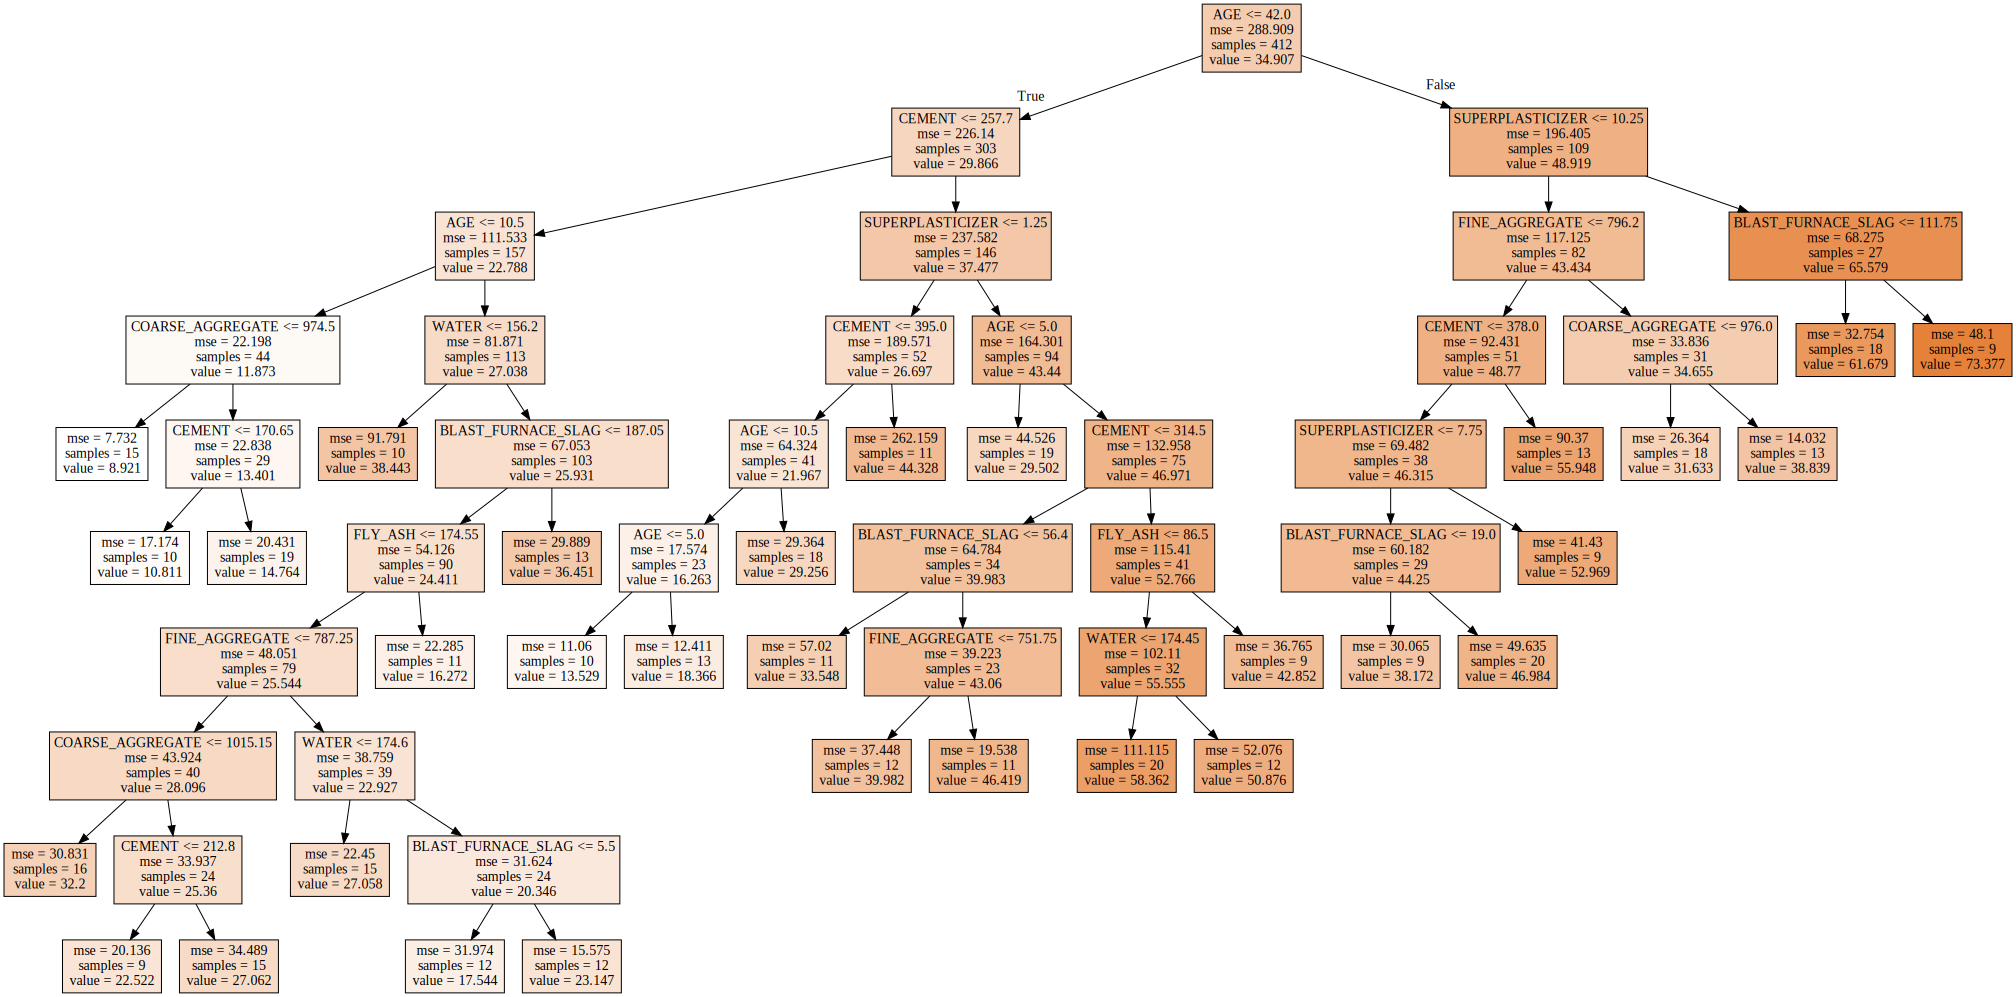

In [20]:
# 위의 결과를 토대로 min_samples_split = 20로 선정
#random_state = 87, min_samples_leaf = 10, min_samples_split = 20을 값으로 하는 의사결정트리 그래프 출력
tree_graph = DecisionTreeRegressor(random_state = 87, min_samples_leaf = 9, min_samples_split = 22)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file="tree_leaf.dot", feature_names=v_feature_name, impurity = True, filled=True)
with open("tree_leaf.dot") as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

In [21]:
# min_samples_leaf = 10, min_samples_split = 20을 고정하여, 의사결정트리의 최대 깊이에 따른 TrainScore, ValidationScore 값 출력
# 최대 깊이의 범위는 4~11
train_score = []; validation_score = []
# max_depth : 최대 깊이 변경
para_depth = [depth for depth in range(4,11)]

for v_max_depth in para_depth :
    tree = DecisionTreeRegressor(random_state = 87, min_samples_leaf = 9, min_samples_split = 22, max_depth = v_max_depth )
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    validation_score.append(tree.score(df_validation_x, df_validation_y))
    
df_score_depth = pd.DataFrame()
df_score_depth["Depth"]=para_depth
df_score_depth["TrainScore"]=train_score
df_score_depth["ValidationScore"]=validation_score
df_score_depth.round(3)

,Depth,TrainScore,ValidationScore
0,4,0.744,0.621
1,5,0.803,0.660
2,6,0.831,0.688
3,7,0.840,0.689
4,8,0.848,0.692
5,9,0.850,0.696
6,10,0.850,0.696


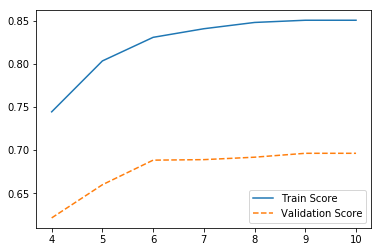

In [22]:
# 최대 깊이 증가에 따라 모델의 설명력은 증가
plt.plot(para_depth,train_score,linestyle="-", label = "Train Score")
plt.plot(para_depth,validation_score,linestyle="--", label = "Validation Score")
plt.legend()
# Train/test 데이터의 성능 변화를 고려하여 6 선택

In [30]:
#min_samples_leaf=10, min_samples_split=20, max_depth = 6을 기반으로 의사결정트리 최종 도출
tree_final = DecisionTreeRegressor(min_samples_leaf=9, min_samples_split=22, max_depth = 7, random_state=87)
tree_final.fit(df_train_x,df_train_y)

DecisionTreeRegressor(criterion='mse', max_depth=7, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=9,
           min_samples_split=22, min_weight_fraction_leaf=0.0,
           presort=False, random_state=87, splitter='best')

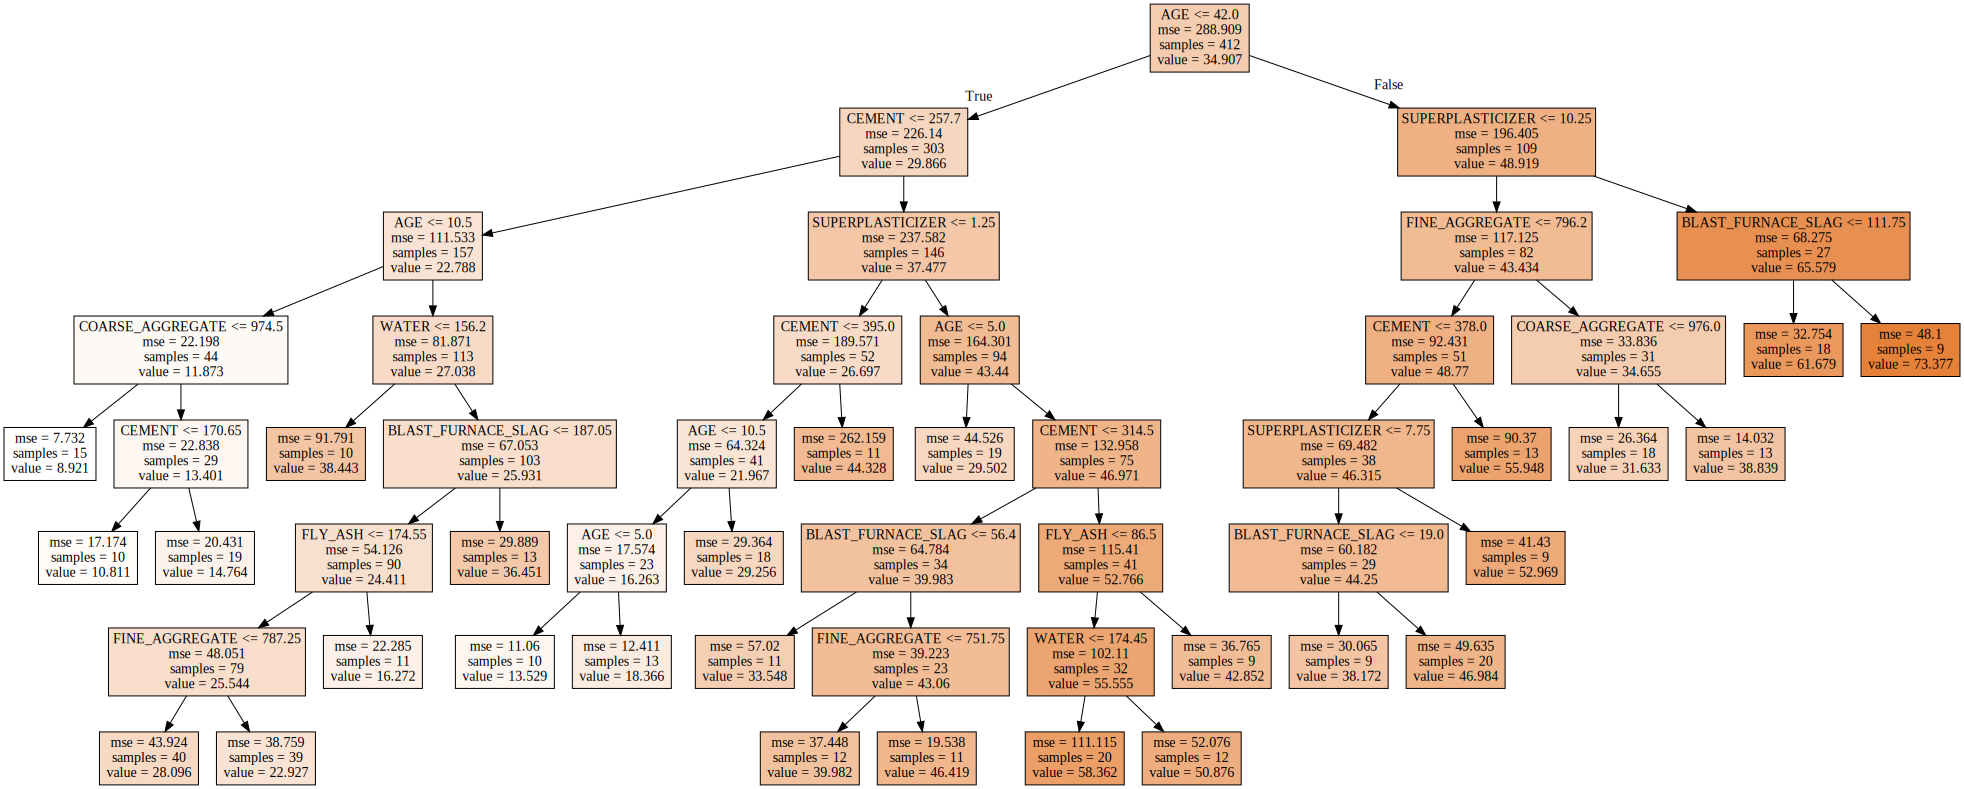

In [31]:
# 최종 의사결정트리 그래프 출력
export_graphviz(tree_final, out_file="tree_final.dot", feature_names=v_feature_name, impurity = True, filled=True)
with open("tree_final.dot") as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

In [32]:
# 최종 의사결정트리 그래프의 TrainScore, ValidationScore 확인
train_score_final=[]; validation_score_final=[]

train_score_final.append(tree.score(df_train_x, df_train_y))
validation_score_final.append(tree.score(df_validation_x, df_validation_y))
    
df_score_final = pd.DataFrame()
df_score_final["MinSamplesLeaf"]= [9]
df_score_final["TrainScore"]=train_score_final
df_score_final["ValidationScore"]=validation_score_final

df_score_final.round(3)

,MinSamplesLeaf,TrainScore,ValidationScore
0,9,0.85,0.696


In [27]:
# test data set을 이용하여 의사결정트리 score 최종 확인
train_score_final=[]; test_score_final=[]

train_score_final.append(tree.score(df_train_x, df_train_y))
test_score_final.append(tree.score(df_test_x, df_test_y))
    
df_score_final = pd.DataFrame()
df_score_final["MinSamplesLeaf"]= [9]
df_score_final["TrainScore"]=train_score_final
df_score_final["TestScore"]=test_score_final

df_score_final.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,9,0.85,0.739


In [33]:
# 각 설명변수의 변수 중요도 값

df_importance = pd.DataFrame()
df_importance["Feature"]=v_feature_name
df_importance["Importance"]=tree_final.feature_importances_

df_importance.sort_values("Importance",ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
7,AGE,0.428
0,CEMENT,0.247
4,SUPERPLASTICIZER,0.199
6,FINE_AGGREGATE,0.046
1,BLAST_FURNACE_SLAG,0.036
2,FLY_ASH,0.020
3,WATER,0.018
5,COARSE_AGGREGATE,0.006


Text(0, 0.5, '변수')

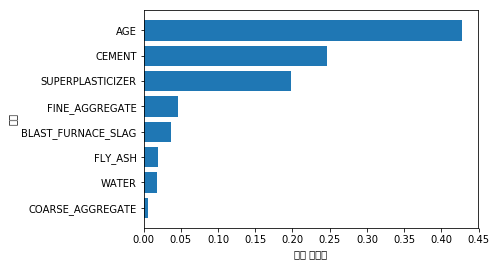

In [34]:
# 각 설명변수의 변수 중요도 값 그래프로 출력

df_importance.sort_values("Importance",ascending = True, inplace = True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

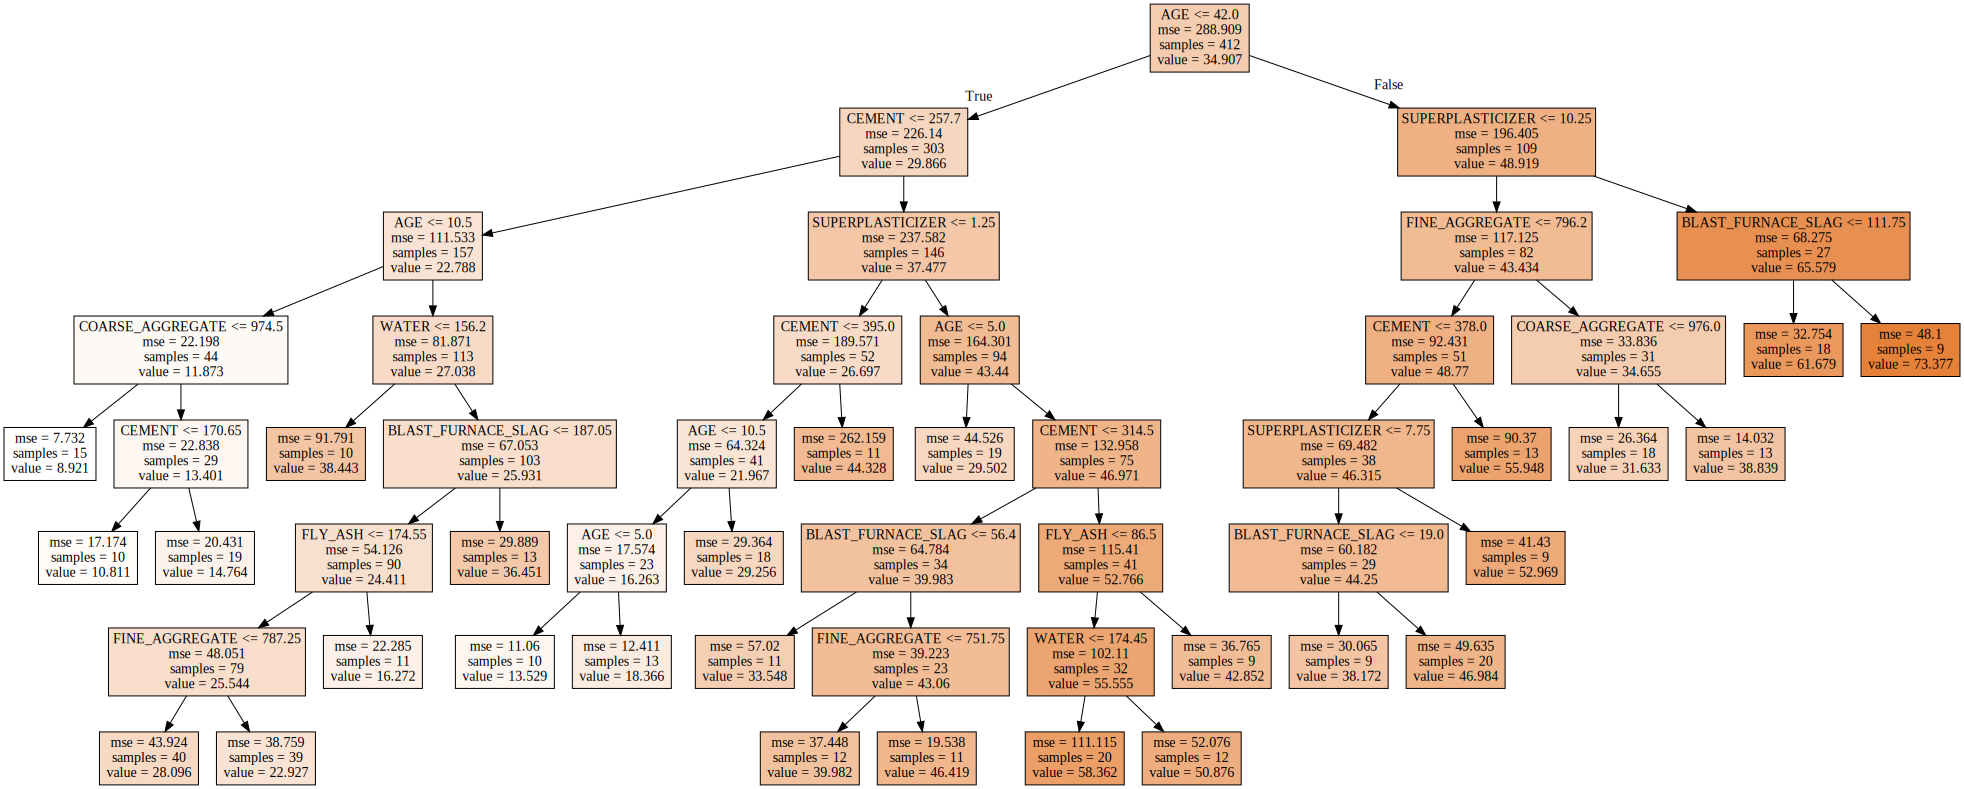

In [35]:
# 최종 의사결정트리 그래프

tree_final_graphviz = DecisionTreeRegressor(min_samples_leaf= 9, min_samples_split= 22, max_depth = 7, random_state=87)
tree_final_graphviz.fit(df_train_x,df_train_y)
export_graphviz(tree_final_graphviz, out_file="tree_final_graphviz.dot", feature_names=v_feature_name, impurity = True, filled=True)
with open("tree_final_graphviz.dot") as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

In [138]:
#graphviz를 이용하여 새로운 의사결정트리 도출
"""
train_score_final_graphviz=[]; validation_score_final_graphviz=[]

train_score_final_graphviz.append(tree_final_graphviz.score(df_train_x, df_train_y))
validation_score_final_graphviz.append(tree_final_graphviz.score(df_validation_x, df_validation_y))
    
df_score_final_graphviz = pd.DataFrame()
df_score_final_graphviz["MinSamplesLeaf"]= [10]
df_score_final_graphviz["TrainScore"]=train_score_final_graphviz
df_score_final_graphviz["ValidationScore"]=validation_score_final_graphviz

df_score_final.round(3)
"""


'\ntrain_score_final_graphviz=[]; validation_score_final_graphviz=[]\n\ntrain_score_final_graphviz.append(tree_final_graphviz.score(df_train_x, df_train_y))\nvalidation_score_final_graphviz.append(tree_final_graphviz.score(df_validation_x, df_validation_y))\n    \ndf_score_final_graphviz = pd.DataFrame()\ndf_score_final_graphviz["MinSamplesLeaf"]= [10]\ndf_score_final_graphviz["TrainScore"]=train_score_final_graphviz\ndf_score_final_graphviz["ValidationScore"]=validation_score_final_graphviz\n\ndf_score_final.round(3)\n'

In [139]:
"""
train_score_final_graphviz=[]; test_score_final_graphviz=[]

train_score_final_graphviz.append(tree_final_graphviz.score(df_train_x, df_train_y))
test_score_final_graphviz.append(tree_final_graphviz.score(df_test_x, df_test_y))
    
df_score_final_graphviz = pd.DataFrame()
df_score_final_graphviz["MinSamplesLeaf"]= [3]
df_score_final_graphviz["TrainScore"]=train_score_final_graphviz
df_score_final_graphviz["TestScore"]=test_score_final_graphviz

df_score_final.round(3)
"""

'\ntrain_score_final_graphviz=[]; test_score_final_graphviz=[]\n\ntrain_score_final_graphviz.append(tree_final_graphviz.score(df_train_x, df_train_y))\ntest_score_final_graphviz.append(tree_final_graphviz.score(df_test_x, df_test_y))\n    \ndf_score_final_graphviz = pd.DataFrame()\ndf_score_final_graphviz["MinSamplesLeaf"]= [3]\ndf_score_final_graphviz["TrainScore"]=train_score_final_graphviz\ndf_score_final_graphviz["TestScore"]=test_score_final_graphviz\n\ndf_score_final.round(3)\n'

In [36]:
#모델의 mse와 mae를 산출하여 비교

rf_MSE = DecisionTreeRegressor(min_samples_leaf= 9, min_samples_split= 22, max_depth = 7, random_state=87)
rf_MSE.fit(df_train_x, df_train_y)

criterion="mae"
rf_MAE = DecisionTreeRegressor(criterion="mae", min_samples_leaf= 9, min_samples_split= 22, max_depth = 7, random_state=87)
rf_MSE.fit(df_train_x, df_train_y)

# 예측값 산출
y_pred = rf_MSE.predict(df_train_x)
df_comparison = pd.DataFrame()
df_comparison["y_predicted"] = y_pred
df_comparison["y_real"]= df_raw_y

df_comparison.round(3)

,y_predicted,y_real
0,42.852,79.99
1,55.948,61.89
2,16.272,40.27
3,50.876,41.05
4,28.096,44.30
5,46.419,47.03
6,38.172,43.70
7,28.096,36.45
8,22.927,45.85
9,58.362,39.29


In [39]:
# 모델의 mse와 mae
# MSE : 실제값과 예측값의 차이의 제곱
# 특이값이 존재하면 수치가 크게 증가한다.

# MAE : 실제값과 예측값의 차이의 절댓값
# 오류 지표를 실제 값과 유사한 단위로 다시 변환하여 해석을 쉽게 한다.
# 절대값을 취하기 때문에 가장 직관적으로 알 수 있는 지표이다.
# MSE 보다 특이치에 영향을 덜 받는다.
# 절대값을 취하기 때문에 모델이 실제보다 높은지 낮은지 알 수 없다.
mse = mean_squared_error(df_train_y, y_pred)
mae = mean_absolute_error(df_train_y, y_pred)
print("MSE :",mse.round(4))
print("MAE :",mae.round(4))

MSE : 46.0833
MAE : 5.1364


# 의사결정트리 모델 시각화 및 해석
# : 트리에 영향이 큰 변수는 AGE, CEMENT, SUPERPLASTICIZER 등이다.
# AGE <= 42.0이면 True(자료 수=291, CONCRETE_COMPRESSIVE_STRENGTH가 35.967에서 30.585로 감소하고 MSE는 감소), AGE > 42.0이면 False(자료 수=121, CONCRETE_COMPRESSIVE_STRENGTH가 35.967에서 48.911로증가하고 MSE는 감소)로 분리한다.
# 그 이후에도 분리 조건을 만족하면 좌측, 만족하지 않으면 우측으로 내려가서 최종 리프를 찾는다.
# 위의 의사결정나무 모델 도출 결과 학습 데이터로는 83.6%, validation 데이터로 parameter들을 조정한 결과 73.9%의 정확도를 보였다.
# 그러나 최종 test 데이터를 적용해봤을 때에 정확도는 72.4%로 다소 감소하였다.
# 또한 건축물의 재료로 쓰이는 콘크리트의 강도를 측정할 때 쓰기에는, 안전에 관련되어 있으므로 이 모델은 쓰지 않는 것이 좋다고 판단된다.